In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

# Data Loading and Augmentation

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


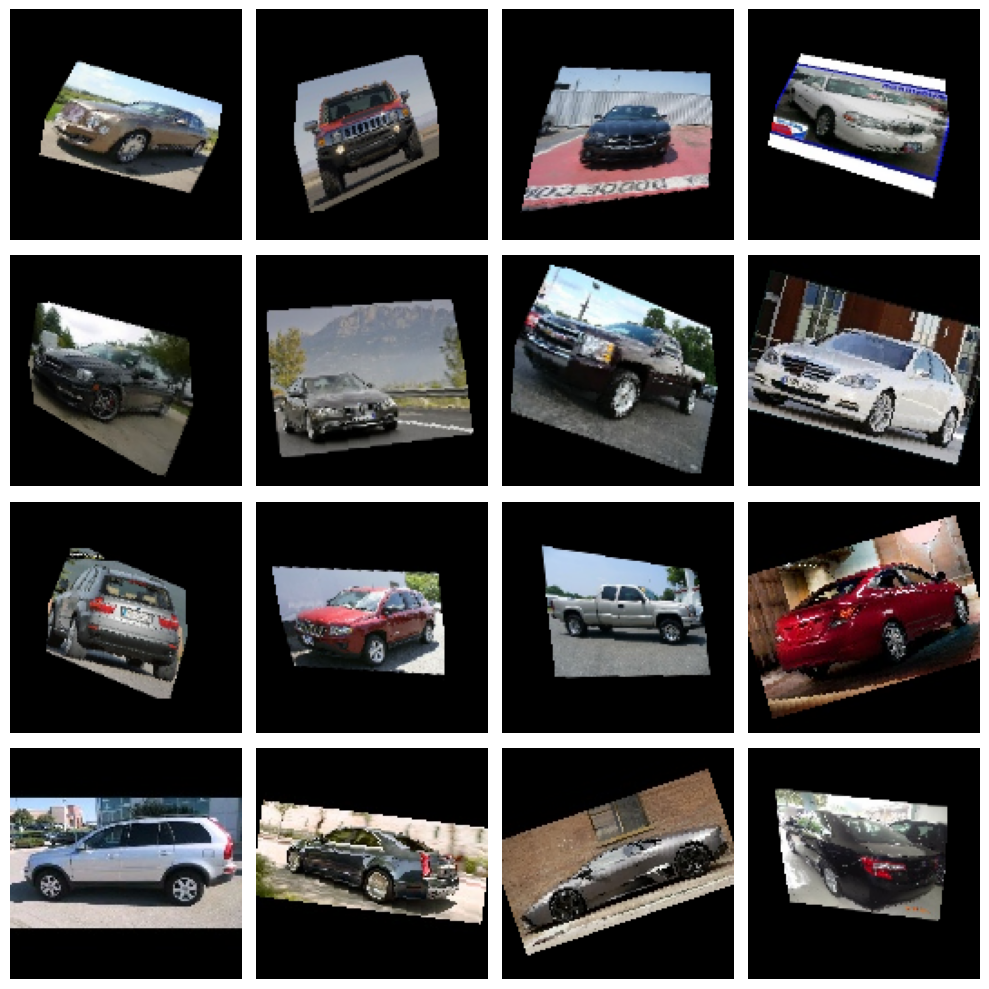

In [2]:
# Data Augmentation Transforms
augment_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(contrast=0.1),
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

# Base transforms for validation set (no augmentation)
base_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='../input/car-or-truck/train',
    transform=augment_transforms
)
valid_dataset = datasets.ImageFolder(
    root='../input/car-or-truck/valid',
    transform=base_transforms
)

# Create data loaders
ds_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

ds_valid = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Found {len(train_dataset)} files belonging to {len(train_dataset.classes)} classes.")
print(f"Found {len(valid_dataset)} files belonging to {len(valid_dataset.classes)} classes.")

# The `unbatch().map()` section is handled implicitly by the DataLoader
# Let's visualize the augmentations
augment_transform_visual = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.RandomPerspective(),
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

ex_dataset = datasets.ImageFolder(
    root='../input/car-or-truck/train',
    transform=augment_transform_visual
)
ex_loader = torch.utils.data.DataLoader(ex_dataset, batch_size=1, shuffle=True)
ex, _ = next(iter(ex_loader))

plt.figure(figsize=(10, 10))
for i in range(16):
    image, _ = next(iter(ex_loader))
    image = image.squeeze(0).permute(1, 2, 0).numpy()
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Model Definition

In [3]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Block One
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Block Two
        self.block2 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Block Three
        self.block3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Head
        self.head = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 8),  # 256 filters, image size is 128x128. After 3 MaxPool layers (2^3=8), the size becomes 16x16.
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

model = ConvNet()

# Training Loop

Epoch 1/50, Loss: 0.8275, Accuracy: 0.4815, Val Loss: 0.7094, Val Accuracy: 0.4581
Epoch 2/50, Loss: 0.6969, Accuracy: 0.4708, Val Loss: 0.6961, Val Accuracy: 0.4377
Epoch 3/50, Loss: 0.6946, Accuracy: 0.4505, Val Loss: 0.6930, Val Accuracy: 0.4977
Epoch 4/50, Loss: 0.6831, Accuracy: 0.4813, Val Loss: 0.6755, Val Accuracy: 0.5151
Epoch 5/50, Loss: 0.6723, Accuracy: 0.5441, Val Loss: 0.6640, Val Accuracy: 0.5789
Epoch 6/50, Loss: 0.6640, Accuracy: 0.5789, Val Loss: 0.6584, Val Accuracy: 0.5783
Epoch 7/50, Loss: 0.6389, Accuracy: 0.5785, Val Loss: 0.6500, Val Accuracy: 0.5787
Epoch 8/50, Loss: 0.6055, Accuracy: 0.5785, Val Loss: 0.6465, Val Accuracy: 0.5785
Epoch 9/50, Loss: 0.5645, Accuracy: 0.6998, Val Loss: 0.5514, Val Accuracy: 0.7549
Epoch 10/50, Loss: 0.4726, Accuracy: 0.7844, Val Loss: 0.4241, Val Accuracy: 0.8212
Epoch 11/50, Loss: 0.3571, Accuracy: 0.8415, Val Loss: 0.3227, Val Accuracy: 0.8650
Epoch 12/50, Loss: 0.2901, Accuracy: 0.8730, Val Loss: 0.3145, Val Accuracy: 0.8654
E

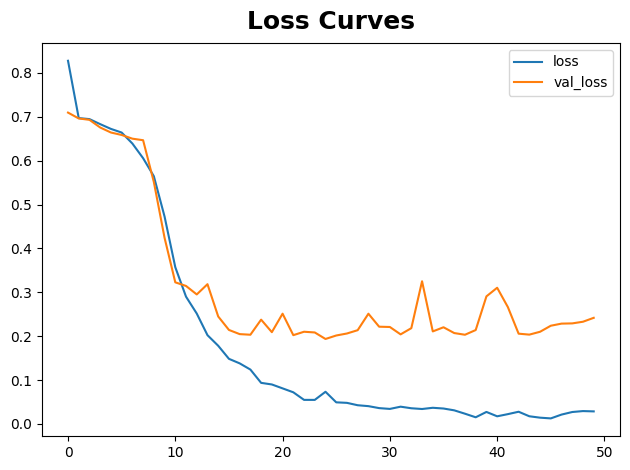

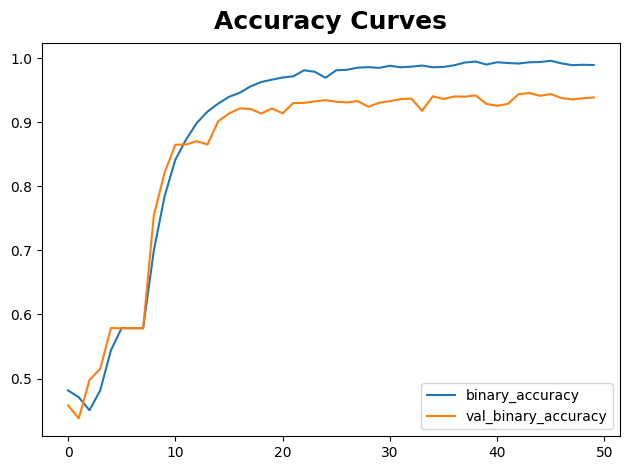

In [4]:
from torch.optim import Adam

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss() # Binary Cross-Entropy Loss

# Training loop
epochs = 50
history = {'loss': [], 'binary_accuracy': [], 'val_loss': [], 'val_binary_accuracy': []}

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in ds_train:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in ds_valid:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            running_val_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = running_val_loss / len(valid_dataset)
    epoch_val_acc = correct_val / total_val

    history['loss'].append(epoch_loss)
    history['binary_accuracy'].append(epoch_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_binary_accuracy'].append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Loss: {epoch_loss:.4f}, '
          f'Accuracy: {epoch_acc:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {epoch_val_acc:.4f}')

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Loss Curves')
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title='Accuracy Curves')
plt.show()